# Neural Network Classifier with MNIST


(Work in progress)

## Libraries

In [1]:
# libraries
#using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, f1score, coerce
using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

#using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
#using Distributions

using Plots; gr()
#using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

In [3]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

function batchImage2DF(imagesArray3D)
    vectorOfImageVectors = batchImage2Vector(imagesArray3D)
    M = reduce(hcat, vectorOfImageVectors)
    DataFrame(M', :auto)
end


batchImage2DF (generic function with 1 method)

## Loading the data

,,,,

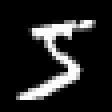
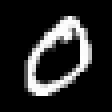
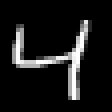
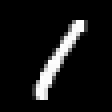
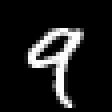

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [5]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Data preprocessing

Data preprocessing depends on the data source, thus can widely vary from what is shown here.

In [6]:
function preprocessing(X, y)
    newX = batchImage2DF(X)
    #coerce!(newX)   # no need, all scitypes are Continuous in this example
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end

X, y = preprocessing(trainX, trainY);

In [7]:
scitype(X)

Table{AbstractVector{Continuous}}

In [8]:
scitype(y)

AbstractVector{OrderedFactor{10}} (alias for AbstractArray{OrderedFactor{10}, 1})

## Training, Testing, Validation

### Load the algorithm

In [9]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux verbosity=0

MLJFlux.NeuralNetworkClassifier

### Instantiate the model


In [10]:
model = NeuralNetworkClassifier(acceleration=CUDALibs())

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    rng = Random._GLOBAL_RNG(),
    optimiser_changes_trigger_retraining = false,
    acceleration = CUDALibs{Nothing}(nothing))

### Create and train the machine


In [11]:
model.epochs=3
mach = MLJ.machine(model, X, y) |> fit!;

┌ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
Optimising neural net:100%[=========================] Time: 0:12:05


In [12]:
fitted_params(mach)

(chain = Chain(Chain(Dense(784, 89, σ), Dropout(0.5), Dense(89, 10)), softmax),)

In [13]:
report(mach)

(training_losses = Float32[2.4227393, 0.43211365, 0.27819902, 0.24491931],)

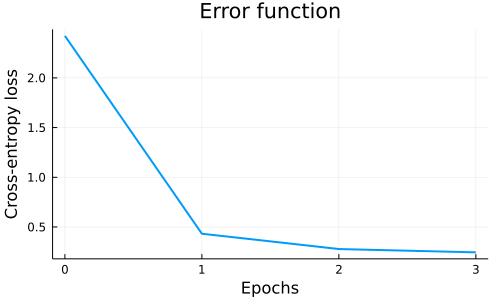

In [21]:
losses = report(mach)[1]
epochs = model.epochs
plot(0:epochs, losses, title="Error function", size=(500,300), linewidth=2, legend=false)
xlabel!("Epochs")
ylabel!("Cross-entropy loss")

### Predict the outcome


In [15]:
ŷ = predict_mode(mach, X)
ŷ[1:5]

5-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 8
 2
 6
 2
 7

In [16]:
printMetrics(ŷ, y)

10×10 Matrix{Int64}:
 4092     1    15     8     2    18    17    10    16    17
    0  4616     6     9     9     5     7     7    30     4
    1    17  4019    44     8    11     4    18    18     2
    4    24    22  4071     3    43     1     1    32    36
    5     6    30     1  3934     9     5    22    11    73
    2     5     7    70     3  3622    15     0    30    11
   23     2    20     8    39    43  4091     2    29     3
    3    14    30    36     9     5     0  4312     7    75
   15    29    21    27     8    21     3     4  3903    20
    1     5     1    18    74    18     0    10    20  3923

accuracy: 0.966
f1-score: 0.966


### Evaluate

In [ ]:
MLJ.evaluate!(mach,
    resampling=CV(nfolds=10),
    measures=[cross_entropy])


Evaluating over 10 folds:  20%[=====>                   ]  ETA: 1:17:58